## Mineria de Datos: Tiempo x Satisfacion
Con el proposito the mejor entender los patrones de satisfacion de paciente ante el tiempo de espera generamos un modelo en base a la mineria de datos del desempeno de varios hospitales en este mismo entorno. Nuestra fuente contine 5000 registros de varios hospitales, detallando el tiempo de demora para que cada reciba cuidad y como evalue el nivel de cuidado al concluir su estadia.

In [46]:
import pandas as pd
data = pd.read_csv('ER Wait Time Dataset.csv')
print(data.shape)
data.head()

(5000, 19)


,Visit ID,Patient ID,Hospital ID,Hospital Name,Region,Visit Date,Day of Week,Season,Time of Day,Urgency Level,Nurse-to-Patient Ratio,Specialist Availability,Facility Size (Beds),Time to Registration (min),Time to Triage (min),Time to Medical Professional (min),Total Wait Time (min),Patient Outcome,Patient Satisfaction
0,HOSP-1-20240210-0001,PAT-00001,HOSP-1,Springfield General Hospital,Urban,2024-02-10 20:20:56,Saturday,Winter,Late Morning,Medium,4,3,92,17,22,66,105,Discharged,1
1,HOSP-3-20241128-0001,PAT-00002,HOSP-3,Northside Community Hospital,Rural,2024-11-28 02:07:47,Thursday,Fall,Evening,Medium,4,0,38,9,30,30,69,Discharged,3
2,HOSP-3-20240930-0002,PAT-00003,HOSP-3,Northside Community Hospital,Rural,2024-09-30 04:02:28,Monday,Fall,Evening,Low,5,1,38,38,40,125,203,Discharged,1
3,HOSP-2-20240227-0001,PAT-00004,HOSP-2,Riverside Medical Center,Urban,2024-02-27 00:31:13,Tuesday,Winter,Evening,High,4,5,94,8,16,64,88,Discharged,2
4,HOSP-1-20240306-0002,PAT-00005,HOSP-1,Springfield General Hospital,Urban,2024-03-06 16:52:26,Wednesday,Spring,Afternoon,Low,4,8,74,26,29,63,118,Discharged,1


Nos enfocaremos en las columnas 'Time to Registration (min)', 'Time to Triage (min)' y 'Time to Medical Professional (min)' como nuestras variables independientes. De estas buscamos encontrar un patron entre el tiempo en cada etapa y la satisfaccion del paciente, tambien como la proporcion de contribucion.

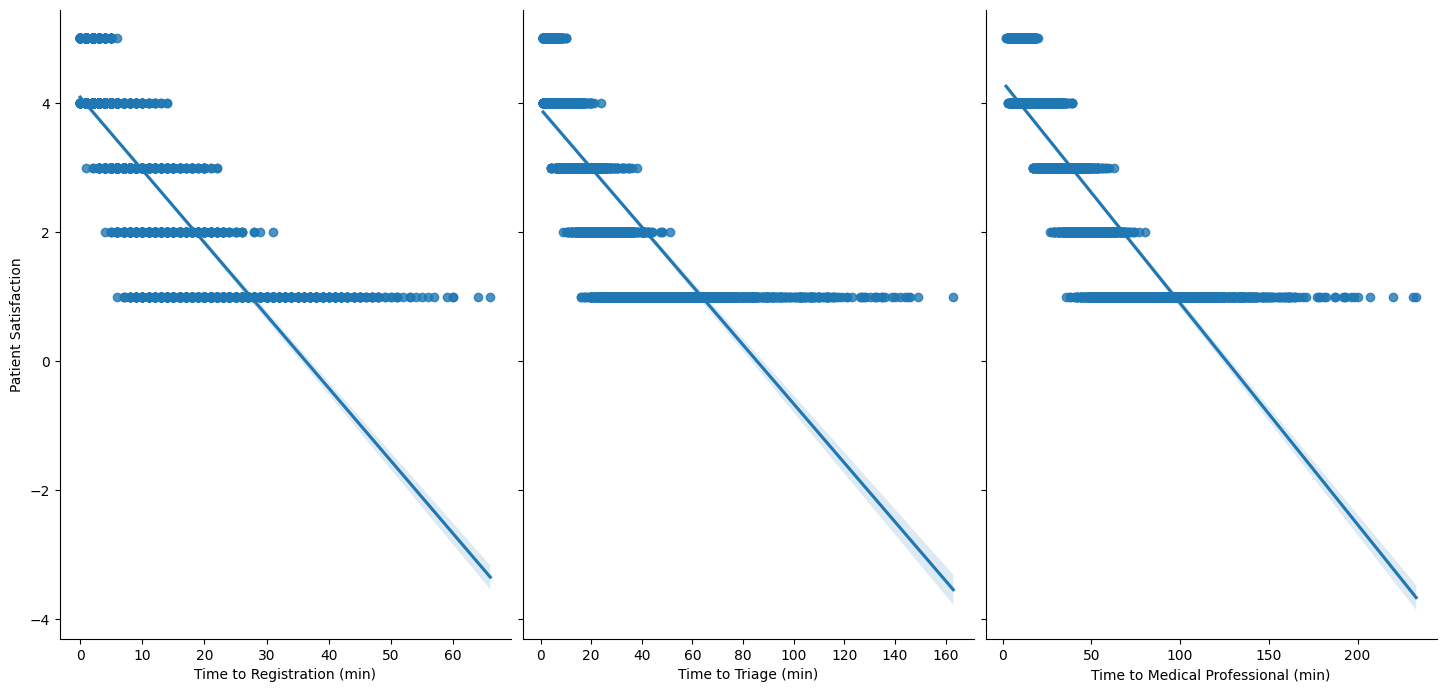

In [27]:
import seaborn as sns
%matplotlib inline
sns.pairplot(data, x_vars=['Time to Registration (min)', 'Time to Triage (min)', 'Time to Medical Professional (min)'], y_vars='Patient Satisfaction', height=7, aspect=0.7, kind='reg')

Separamos nuestros datos entre datos de entrenamiento y datos de prueba para el modelo.

In [28]:
from sklearn.model_selection import train_test_split
X = data[['Time to Registration (min)', 'Time to Triage (min)', 'Time to Medical Professional (min)']]
y = data['Patient Satisfaction']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3750, 3)
(3750,)
(1250, 3)
(1250,)


Con los datos (3750 filas de entrenamiento, 1250 filas de pruba) hacemos entrenamos un modelo de regression lineal multivariable.

In [29]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)
print(linreg.intercept_)
print(linreg.coef_)

4.313652542575053
[-0.03914538 -0.00486772 -0.02143433]


Nuestro modelo resultante es: $$y = 4.31 - 0.039 \\times T_registro - 0.0048 \\times T_triaje - 0.021 \\times T_medico$$
Es decire que:
- Cada 25 minutos en espera sin registro
- Cada 208 minutos en espera sin triaje
- cada 48 minutos en espera sin un medico
reduces la satisfaccion de los pacientes por 1 punto.

Para corroborar la certeza de nuestro modelo, calculamos la raiz media cuadrada.

In [30]:
from sklearn import metrics
import numpy as np
y_pred = linreg.predict(X_test)
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

0.7218549159267275


El valor resultante es bueno, pero es possible que una o mas de las variables dependientes nos son realmente contribuyentes a la dependiente. Para eso calcularemos el error para cada combinacion individual.

In [33]:
def calculateRMS(data, inputCols):
    X = data[inputCols]
    
    y = data['Patient Satisfaction']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

    linreg.fit(X_train, y_train)
    y_pred = linreg.predict(X_test)
    return np.sqrt(metrics.mean_squared_error(y_test, y_pred))

rmsTable = {
        'Variables': ['Registration', 'Triage', 'Medic', 'Registration+Tiage', 'Registration+Medic', 'Triage+Medic', 'All'],
        'RMS': [calculateRMS(data, ['Time to Registration (min)']),
                calculateRMS(data, ['Time to Triage (min)']),
                calculateRMS(data, ['Time to Medical Professional (min)']),
                calculateRMS(data, ['Time to Registration (min)', 'Time to Triage (min)']),
                calculateRMS(data, ['Time to Registration (min)', 'Time to Medical Professional (min)']),
                calculateRMS(data, ['Time to Triage (min)', 'Time to Medical Professional (min)']),
                calculateRMS(data, ['Time to Registration (min)', 'Time to Triage (min)', 'Time to Medical Professional (min)'])]
    }
print(pd.DataFrame(rmsTable))

            Variables       RMS
0        Registration  0.823600
1              Triage  0.872757
2               Medic  0.755766
3  Registration+Tiage  0.788428
4  Registration+Medic  0.723279
5        Triage+Medic  0.743811
6                 All  0.721855


Resulta que la combinacion con el error mas pequeno es la que incluye todas las variables, confirmando que todas la independientes contribuyen a la satisfaccion del paciente. Sin embargo, al revisar los patrones, vemos que el tiempo de triaje affecta muy disminuidamente al resultado. Por ende trataremos de incrementar la precision de nuestro modelos, acotando los datos utilizado.

Solo utilizaremos los datos que no sobrepasen de cierto criterio de tiempo de espera, ya que la satisfacion no va a valores menores de 1, causando anomalias en nuestro modelado.

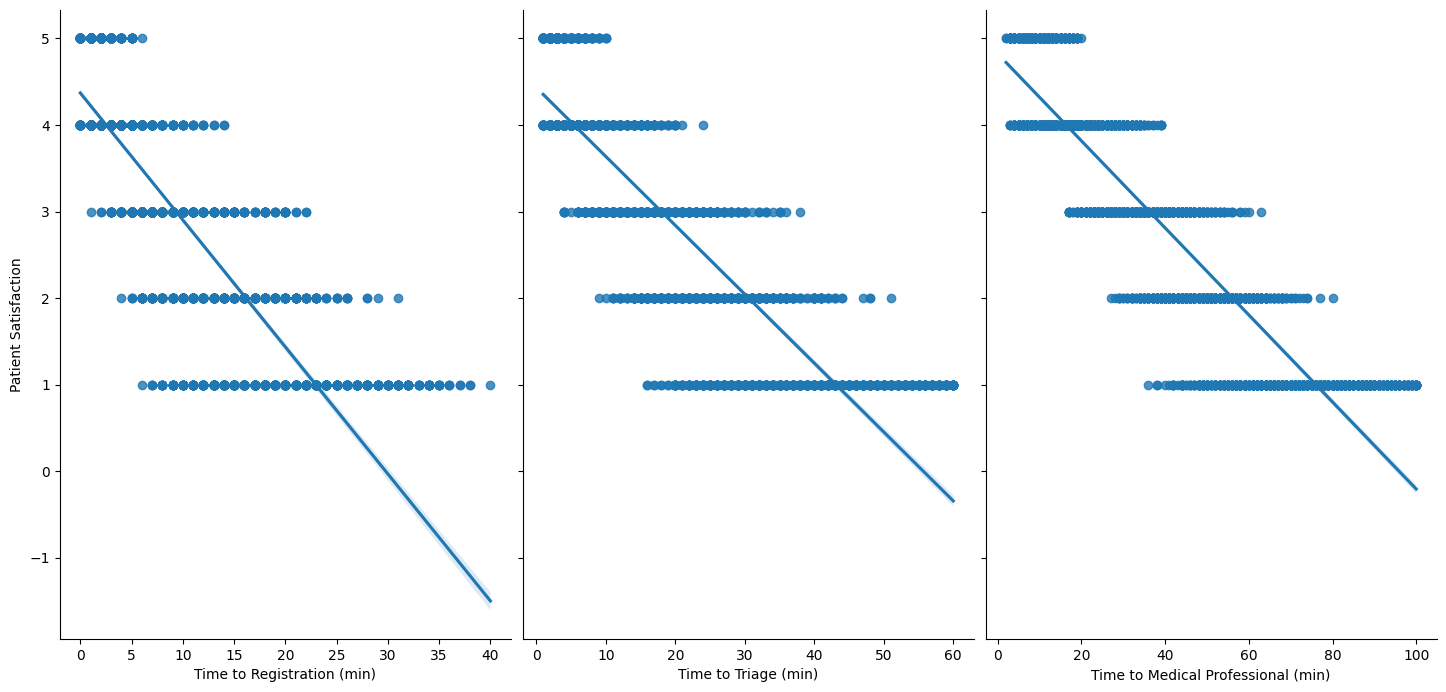

In [50]:
fdf = data[(data['Time to Registration (min)'] <= 40) & (data['Time to Triage (min)'] <= 60) & (data['Time to Medical Professional (min)'] <= 100)]
sns.pairplot(fdf, x_vars=['Time to Registration (min)', 'Time to Triage (min)', 'Time to Medical Professional (min)'], y_vars='Patient Satisfaction', height=7, aspect=0.7, kind='reg')

In [55]:
X = fdf[['Time to Registration (min)', 'Time to Triage (min)', 'Time to Medical Professional (min)']]
y = fdf['Patient Satisfaction']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
linreg = LinearRegression()
linreg.fit(X_train, y_train)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3261, 3)
(3261,)
(1087, 3)
(1087,)


Nuestro nuevo conjunto reduce a 3261 filas de entrenamiento y 1087 filas para la prueba.

In [52]:
print(linreg.intercept_)
print(linreg.coef_)
y_pred = linreg.predict(X_test)
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

4.801071079068204
[-0.0271315  -0.02701728 -0.02948612]
0.4750049643685254


De esta forma hemos reducido el error aun mas. Nuestro modelo final es: $$y = 4.31 - 0.027 \\times T_registro - 0.027 \\times T_triaje - 0.029 \\times T_medico$$
Ahora vemos que la contribucion de cada tiempo es similar, significando que cada tiempo de espera tiene misma importancia para el paciente.
Haremos un prediccion con nuestro modelo para el caso promedio de nuestro hospital:$$T_registro = 12.52, T_triaje = 25.33, T_medico = 47.93$$

In [61]:
final_pred = linreg.predict(np.array([[12.52,25.33,47.93]]))
print(final_pred[0])

2.363767475115797


d:\UCA\bi\Bi_proyecto\Mineria de Datos\mine_venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Nuestra satisfacion estimada en comparacion a otros hospitales es: $$2.36$$